## Testing on LFW Dataset
------------------------

In [1]:
import os 
import torch
from torch.utils.data import DataLoader
from torch import nn
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import torchsummary

os.chdir('..') # If running from the /Notebooks directory
print(os.getcwd()) # Should be ...\ContrastiveLearning
from Code.dataloaders import LFWContrastiveDataset
from Code.testers import Tester
from Code.models import ContrastiveModel
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score

# Hyperparameters
THRESHOLD = 0.5
METRIC = recall_score
METRIC_NAME = "RECALL" + "_@_" + str(THRESHOLD)
IN_CHANNELS = 3
EMB_SIZE = 4096
MODEL_WEIGHTS = "./Outputs/Weights/20_4096_0.0005.pth"
DEVICE = 'cuda'
SEED = 42
N = 100

# Reproduciblity
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

F:\Research\ContrastiveLearning


## Initializing Test Set
-------------------------

In [2]:
lfw = LFWContrastiveDataset(data_path = r'./Data/Test/', 
                            resize_to=(105,105))

In [3]:
outdict = lfw.__getitem__(4)
[outdict[k].shape for k in outdict.keys()]

[torch.Size([5, 3, 105, 105]),
 torch.Size([5, 3, 105, 105]),
 torch.Size([5, 1])]

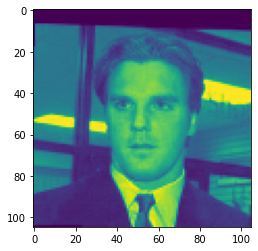

In [4]:
idx = 0
plt.imshow(outdict["x1"][idx,0,...])

tensor([1.])


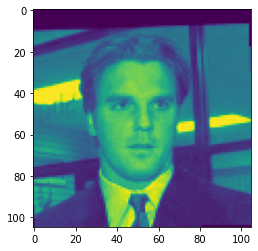

In [5]:
plt.imshow(outdict["x2"][idx,0,...]); print(outdict["label"][idx])

In [6]:
subset_indices = list(range(100)) # Limit examples for testing 
subset_sampler = torch.utils.data.SubsetRandomSampler(subset_indices)
lfw_dl = torch.utils.data.DataLoader(lfw, 
                                     batch_size=None,
                                     sampler = subset_sampler)

## Load Model
--------------

In [7]:
model = ContrastiveModel(IN_CHANNELS, EMB_SIZE).to(DEVICE)
model.load_state_dict(torch.load(MODEL_WEIGHTS))
torchsummary.summary(model, input_size = (3, 105, 105), device=DEVICE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]          19,264
              ReLU-2           [-1, 64, 96, 96]               0
         MaxPool2d-3           [-1, 64, 48, 48]               0
            Conv2d-4          [-1, 128, 42, 42]         401,536
              ReLU-5          [-1, 128, 42, 42]               0
         MaxPool2d-6          [-1, 128, 21, 21]               0
            Conv2d-7          [-1, 128, 18, 18]         262,272
         MaxPool2d-8            [-1, 128, 9, 9]               0
              ReLU-9            [-1, 128, 9, 9]               0
           Conv2d-10            [-1, 256, 6, 6]         524,544
             ReLU-11            [-1, 256, 6, 6]               0
           Linear-12                 [-1, 4096]      37,752,832
Total params: 38,960,448
Trainable params: 38,960,448
Non-trainable params: 0
-------------------------

# Initialize Tester
----------------------

In [8]:
metric = accuracy_score

t = Tester(model = model, 
           dataloader = lfw_dl, 
           metric = metric)
